In [1]:
import sys
sys.path.insert(1, "../python/architecture")
sys.path.insert(2, "../python/functions")

In [87]:
import numpy as np
from inverse_problem_functions import y_noise
from enkf_functions import enkf_inverse_problem
from plotting_functions import plot_IP_loss_evolution# , plot_IP_loss_evolution_many, plot_IP_true_false, plot_IP_particle_loss, plot_IP_particle_std, plot_IP_iteration_std
from sklearn.metrics import mean_squared_error

In [103]:
def enkf_linear_inverse_problem(setting_dict,
                                analysis_dict
                                ):

    """ Ensemble Kalman Filter algorithm applied to an inverse problem.


    Parameters:

    setting_dict (dict): Dictionary containing
        model_func (function): Function to apply to x.
        x (np.array): True parameters.
        y (np.array): True target variable.
        particles (int): Number of particles in the ensemble.
        iterations (int): Number of iterations.
        noise (bool): Whether or not to add noise to the target variable.
        std (np.array): Standard deviation of the noise.
        h_0 (int or float): Starting step size.
        epsilon (float): Constant for numerical stability in the step size.
        randomization (bool): Whether or not to add noise to the particles and randomize them around their mean.


    Returns:

    final_params (np.ndarray): Final predicted parameter.
    loss_evolution (list): Evolution of the loss value over each iteration.
    loss_evolution_single_dict (dict): Evolutions of loss values of all particles.

    """

    A = setting_dict["A"]
    x = setting_dict["x"]
    y = setting_dict["y"]
    particles = setting_dict["particles"]
    iterations = setting_dict["iterations"]
    batch_size = setting_dict["batch_size"]
    noise = setting_dict["noise"]
    std = setting_dict["std"]
    h_0 = setting_dict["h_0"]
    epsilon = setting_dict["epsilon"]
    randomization = setting_dict["randomization"]
    
    batch_particle_connection = analysis_dict["batch_particle_connection"]["connect"]
    update_all = analysis_dict["batch_particle_connection"]["update_all"]

    if noise and any(std == None):
        raise ValueError("If noise is True, then std can not be None.")

    def loss(y_true, y_pred):
        if not noise:
            return mean_squared_error(y_true, y_pred)
        else:
            return np.mean(np.dot(np.sqrt(np.linalg.inv(np.diag(std))), y_true - y_pred)**2)

    def grad_loss(y_true, y_pred):
        if not noise:
            return (-2) / y_true.shape[0] * (y_true - y_pred)
        else:
            return (-2) / y_true.shape[0] * np.diag(np.sqrt(np.linalg.inv(np.diag(std)))) * (y_true - y_pred)
        
    if batch_size is None:
        batch_size = len(x)
    n = len(x)
    num_batches = int(np.ceil(n / batch_size))
    batch_indices = np.cumsum([0] + list(np.ones(num_batches) * batch_size))
    batch_indices[-1] = n
    
    indices = np.arange(n)
    A_batches = [A[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
    y_batches = [y[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
    
    if batch_particle_connection:
        batch_particle_dict = {}
        batch_particle_indices = np.arange(particles) + 1
        np.random.shuffle(batch_particle_indices)
        if particles == num_batches:
            for i in range(num_batches):
                batch_particle_dict["batch_{}".format(str(i+1))] = batch_particle_indices[i]
        elif particles > num_batches:
            base_batches = particles // num_batches
            add_batches = particles % num_batches
            for i in range(num_batches):
                batch_particle_dict["batch_{}".format(str(i+1))] = batch_particle_indices[:base_batches]
                batch_particle_indices = batch_particle_indices[base_batches:]
            for i in range(add_batches):
                batch_particle_dict["batch_{}".format(str(i+1))] = np.concatenate([batch_particle_dict["batch_{}".format(str(i+1))], np.array([batch_particle_indices[i]])])
        elif num_batches > particles:
            num_reps = int(np.ceil(num_batches / particles))
            particles_repeated = np.tile(batch_particle_indices, num_reps)
            for i in range(num_batches):
                batch_particle_dict["batch_{}".format(str(i+1))] = particles_repeated[i]

    param_dict = {}
    y_pred_dict = {}
    jacobian_dict = {}
    loss_dict = {}

    for i in range(particles):
        param_dict["particle_{}".format(i+1)] = np.random.normal(loc = 0, scale = 1, size = x.shape)
        y_pred_dict["particle_{}".format(i+1)] = np.dot(A, param_dict["particle_{}".format(i+1)])
        jacobian_dict["particle_{}".format(i+1)] = grad_loss(y, y_pred_dict["particle_{}".format(i+1)])
        loss_dict["particle_{}".format(i+1)] = loss(y, y_pred_dict["particle_{}".format(i+1)])

    param_mean = np.mean(list(param_dict.values()), axis = 0)

    loss_evolution = []
    loss_evolution.append(loss(y, np.dot(A, param_mean)))

    loss_evolution_single_dict = {}
    for i in range(particles):
        loss_evolution_single_dict["particle_{}".format(i+1)] = [loss(y, np.dot(A, param_dict["particle_{}".format(i+1)]))]

    for iteration in range(iterations):
        for b in range(num_batches):
            batch_particles = []
            # update the predictions, jacobian and loss for the new parameters
            for i in range(particles):
                if batch_particle_connection: 
                    if num_batches == particles or num_batches > particles:
                        if batch_particle_dict["batch_{}".format(str(b+1))] != i+1:
                            continue
                    else:
                        if i+1 not in batch_particle_dict["batch_{}".format(str(b+1))]:
                            continue
                if batch_particle_connection:
                    batch_particles.append(i+1)
                    
                y_pred_dict["particle_{}".format(i+1)] = np.dot(A_batches[b], param_dict["particle_{}".format(i+1)])
                jacobian_dict["particle_{}".format(i+1)] = grad_loss(y_batches[b], y_pred_dict["particle_{}".format(i+1)])
                loss_dict["particle_{}".format(i+1)] = loss(y_batches[b], y_pred_dict["particle_{}".format(i+1)])

            # compute the mean of the predictions
            y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)

            # compute the matrix D elementwise
            d = np.zeros(shape = (particles, particles))
            for k in range(particles):
                y_pred_centered = y_pred_dict["particle_{}".format(str(k+1))] - y_pred_mean
                for j in range(particles):
                    d[k][j] = np.dot(y_pred_centered, jacobian_dict["particle_{}".format(str(j+1))])
            d = np.transpose(d)

            # compute the scalar h_t
            h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)

            # matrix with particle parameters as row vectors
            params_all_ptcls = np.array(list(param_dict.values()))

            # compute the matrix with the updates for each particle
            params_all_ptcls = params_all_ptcls - h_t * np.dot(d, params_all_ptcls)

            # write the updates back into the dictionary
            for i in range(particles):
                if batch_particle_connection:
                    if not update_all:
                        if i not in batch_particles:
                            continue
                param_dict["particle_{}".format(str(i+1))] = params_all_ptcls[i]

                if randomization:
                    # add randomization/ noise to each particle
                    stddev = 0.1
                    noise = np.random.normal(loc = 0.0,
                                             scale = stddev,
                                             size = param_dict["particle_{}".format(str(i+1))].shape)
                    new_param = param_dict["particle_{}".format(str(i+1))] + noise
                    param_dict["particle_{}".format(str(i+1))] = new_param

            if randomization:
                # randomize particles around their mean
                param_dict_mean = list(np.mean(list(param_dict.values()), axis = 0))
                for i in range(particles):
                    stddev = 0.1
                    noise = np.random.normal(loc = 0.0,
                                             scale = stddev,
                                             size = param_dict["particle_{}".format(str(i+1))].shape)
                    new_params = param_dict_mean + noise
                    param_dict["particle_{}".format(str(i+1))] = new_params

        # compute loss for the parameter means
        param_mean = np.mean(params_all_ptcls, axis = 0)
        loss_evolution.append(loss(y, np.dot(A, param_mean)))

        for i in range(particles):
            loss_evolution_single_dict["particle_{}".format(i+1)].append(loss(y, np.dot(A, param_dict["particle_{}".format(i+1)])))

    final_params = param_mean

    return final_params, loss_evolution, loss_evolution_single_dict

# Lineares Modell

## Modell:
$Ax=y$ mit $A$ $m\times n$-Matrix, $m$, $n$ beliebig ($A$ also insbesondere nicht zwingend quadratisch).

$x$ wird gesucht.

In [80]:
A = np.random.uniform(size = (1000, 1000))
x = np.random.uniform(size = (A.shape[1], ))

In [81]:
def model_func(x):
    return np.dot(A, x)

In [82]:
noise = False

y, std = y_noise(model_func,
                 x, 
                 noise)

In [106]:
setting_dict = {"A": A,
                "x": x,
                "y": y,
                "particles": 100,
                "iterations": 10,
                "batch_size" : 50,            
                "noise": noise,
                "std": std,
                "h_0": 2,
                "epsilon": 0.5,
                "randomization": False
                }
analysis_dict = {"batch_particle_connection": {"connect": True,
                                               "update_all": False}}

In [107]:
final_params, loss_evolution, loss_evolution_single_dict = enkf_linear_inverse_problem(setting_dict,
                                                                                       analysis_dict)
plot_IP_loss_evolution(loss_evolution,
                       start_iteration = 1,
                       save = None)
loss_evolution[-10:]

c:\users\morit\anaconda3\envs\master_thesis\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


ValueError: operands could not be broadcast together with shapes (1000,) (50,) 

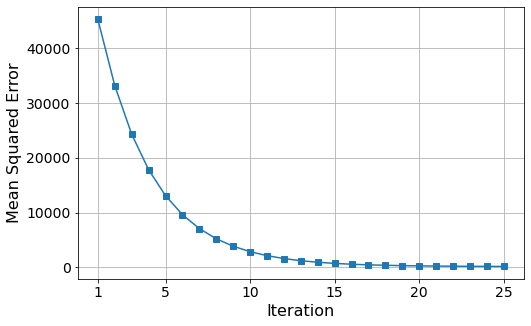

[590.395237510239,
 478.49565832033545,
 396.2738433762962,
 335.6416975749094,
 290.6926260373185,
 257.13850321101023,
 231.88799128306147,
 212.72472382788132,
 198.06209653502498,
 186.7604162465239]

In [100]:
setting_dict = {"model_func": model_func,
                "x": x,
                "y": y,
                "particles": 100,
                "iterations": 25,
                "noise": noise,
                "std": std,
                "h_0": 2,
                "epsilon": 0.5,
                "randomization": False
                }
final_params_inv, loss_evolution_inv, loss_evolution_single_dict_inv = enkf_inverse_problem(setting_dict)
plot_IP_loss_evolution(loss_evolution_inv,
                       start_iteration = 1,
                       save = None)
loss_evolution_inv[-10:]

## Modell:
$Ax=y + \eta$ mit $A$ $m\times n$-Matrix, $m$, $n$ beliebig ($A$ also insbesondere nicht zwingend quadratisch), $\eta\sim\mathscr{N}(0,\Gamma)$.

$x$ wird gesucht.